In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [49]:
# URL of the CSV file (example)
url = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2023-24/gws/merged_gw.csv"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(url)

In [611]:
temp_fixtures=pd.read_csv("https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/refs/heads/master/data/2020-21/fixtures.csv")
temp.columns
#team_h_dif is the difficultly of the home team player

Index(['name', 'id', 'strength', 'strength_overall_home',
       'strength_overall_away', 'strength_attack_home', 'strength_attack_away',
       'strength_defence_home', 'strength_defence_away'],
      dtype='object')

In [612]:
temp_teams=pd.read_csv("https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/refs/heads/master/data/2020-21/teams.csv")
temp=temp_teams[['name', 'id', 'strength', 'strength_overall_home', 'strength_overall_away', 'strength_attack_home', 'strength_attack_away', 'strength_defence_home', 'strength_defence_away']]
temp.columns
#team_h_dif is the difficultly of the home team player

Index(['name', 'id', 'strength', 'strength_overall_home',
       'strength_overall_away', 'strength_attack_home', 'strength_attack_away',
       'strength_defence_home', 'strength_defence_away'],
      dtype='object')

In [614]:
temp_away=temp[['name', 'id', 'strength', 'strength_overall_away', 'strength_attack_away', 'strength_defence_away']]
temp_home=temp[['name', 'id', 'strength', 'strength_overall_home', 'strength_attack_home', 'strength_defence_home']]


In [617]:
# Merge for team_a (away team)
temp_fixtures = temp_fixtures.merge(
    temp_away,
    how='left',
    left_on='team_a',
    right_on='id',
    suffixes=('', '_team_a')
)

# Merge for team_h (home team)
temp_fixtures = temp_fixtures.merge(
    temp_home,
    how='left',
    left_on='team_h',
    right_on='id',
    suffixes=('', '_team_h')
)

temp_fixtures.columns

Index(['code', 'event', 'finished', 'finished_provisional', 'id',
       'kickoff_time', 'minutes', 'provisional_start_time', 'started',
       'team_a', 'team_a_score', 'team_h', 'team_h_score', 'stats',
       'team_h_difficulty', 'team_a_difficulty', 'pulse_id', 'name',
       'id_team_a', 'strength', 'strength_overall_away',
       'strength_attack_away', 'strength_defence_away', 'name_team_h',
       'id_team_h', 'strength_team_h', 'strength_overall_home',
       'strength_attack_home', 'strength_defence_home'],
      dtype='object')

In [619]:
temp_fixtures.head(5)

,code,event,finished,finished_provisional,id,kickoff_time,minutes,provisional_start_time,started,team_a,team_a_score,team_h,team_h_score,stats,team_h_difficulty,team_a_difficulty,pulse_id,name,id_team_a,strength,strength_overall_away,strength_attack_away,strength_defence_away,name_team_h,id_team_h,strength_team_h,strength_overall_home,strength_attack_home,strength_defence_home
0,2128288,1,True,True,2,2020-09-12T11:30:00Z,90,False,True,1,3,8,0,"[{'identifier': 'goals_scored', 'a': [{'value'...",3,2,58898,Arsenal,1,4,1250,1150,1210,Fulham,8,3,1090,1150,1040
1,2128287,1,True,True,1,2020-09-12T14:00:00Z,90,False,True,16,0,6,1,"[{'identifier': 'goals_scored', 'a': [], 'h': ...",2,3,58897,Southampton,16,3,1100,1110,1160,Crystal Palace,6,3,1090,1030,1010
2,2128289,1,True,True,3,2020-09-12T16:30:00Z,90,False,True,10,3,11,4,"[{'identifier': 'goals_scored', 'a': [{'value'...",3,3,58899,Leeds,10,3,1170,1150,1170,Liverpool,11,4,1250,1190,1300
3,2128293,1,True,True,6,2020-09-12T19:00:00Z,90,False,True,14,2,19,0,"[{'identifier': 'goals_scored', 'a': [{'value'...",2,4,58903,Newcastle,14,2,1070,1060,1110,West Ham,19,4,1230,1140,1260
4,2128292,1,True,True,5,2020-09-13T13:00:00Z,90,False,True,9,3,18,0,"[{'identifier': 'goals_scored', 'a': [{'value'...",4,2,58902,Leicester,9,4,1260,1150,1230,West Brom,18,2,1050,1040,1050


In [621]:
def fetch_data(url, players_url, fix_url, teams_url):

    # Read CSVs
    df = pd.read_csv(url, encoding="latin1")
    df2 = pd.read_csv(players_url)
    df_fix_raw=pd.read_csv(fix_url)
    df_teams_raw=pd.read_csv(teams_url)

    # Dropping unnecessary columns and creating first_name and last_name for join
    df[['first_name', 'second_name']] = df['name'].str.split(' ', n=1, expand=True)
    df2=df2[['first_name', 'second_name', 'team', 'web_name']]
    df_fix=df_fix_raw[['id', 'team_h_difficulty', 'team_a_difficulty']]
    df_teams=df_teams_raw[['name', 'strength', 'strength_overall_home', 'strength_overall_away', 'strength_attack_home', 'strength_attack_away', 'strength_defence_home', 'strength_defence_away']]


    
    if 'expected_assists' in df.columns:
        df.drop('expected_assists', axis=1, inplace=True)
        df.drop('expected_goal_involvements', axis=1, inplace=True)
        df.drop('expected_goals', axis=1, inplace=True)
        df.drop('expected_goals_conceded', axis=1, inplace=True)
        df.drop('starts', axis=1, inplace=True)

    # Creating 'form' column which is mean of total points from the last 5 GWs
    df = df.sort_values(by=['name', 'GW'])
    df['form'] = (
    df.groupby('name')['total_points']
    .apply(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
    .reset_index(level=0, drop=True)  # Ensure the index matches the original DataFrame
    )
    df['form'] = df.groupby('name')['form'].transform(lambda x: x.fillna(0))

    # Taking cummulative stats from the previous GWs
    columns_to_cumsum = ['goals_scored', 'assists', 'bonus', 'yellow_cards', 'clean_sheets', 'goals_conceded']

    # Apply cumulative sum for each column grouping by 'name', excluding the current row
    for col in columns_to_cumsum:
        df[col] = df.groupby('name')[col].cumsum().shift(1, fill_value=0)

    df.update(
    df.groupby('name')[columns_to_cumsum].transform(lambda x: x.mask(x.index == x.index.min(), 0))
    )

    df['cumulative_minutes'] = (
    df.groupby('name')['minutes']
    .cumsum()                # Compute cumulative sum
    .shift(1, fill_value=0)  # Shift down by 1 row, keeping first as 0
    )
    df['cumulative_minutes'] = df.groupby('name')['cumulative_minutes'].transform(
    lambda x: x.mask(x.index == x.index.min(), 0)
    )

    df = df.groupby('name').filter(lambda x: x['cumulative_minutes'].iloc[-1] >= 600)

    #Merging fixtures dataframe to get 'fixture difficulty'
    df=pd.merge(df, df_fix, left_on='fixture', right_on='id', how='left')
    
    df['fixture_difficulty']=np.where(df['was_home'], df['team_h_difficulty'], df['team_a_difficulty'])

    # Merging teams dataframe to obtain team strength stats
    df=pd.merge(df, df_teams, left_on='team', right_on='name', how='left')
    df['strength_overall']=np.where(df['was_home'], df['strength_overall_home'], df['strength_overall_away'])
    df['strength_attack']=np.where(df['was_home'], df['strength_attack_home'], df['strength_attack_away'])
    df['strength_defence']=np.where(df['was_home'], df['strength_defence_home'], df['strength_defence_away'])

    
    df=df.drop(['team_h_difficulty', 'team_a_difficulty', 'team_a_score', 'team_h_score', 'opponent_team', 'xP', 'kickoff_time', 'element', 'fixture'], axis=1)
    
    # Merging df2 to get team name
    merged_df=pd.merge(df, df2, on=['first_name', 'second_name'], how='inner')
    merged_df=merged_df.drop(['team_x', 'team_y', 'first_name', 'second_name', 'bps', 'round', 'name_y', 'id', 'minutes', 'own_goals', 'strength_overall_home', 'strength_overall_away', 'strength_attack_home', 'strength_attack_away', 'strength_defence_home', 'strength_defence_away', 'transfers_balance', 'GW', 'saves', 'penalties_missed', 'penalties_saved'],axis=1)
    print(merged_df.columns)

    # Seperating all positions to different dataframes
    gks=merged_df.loc[(merged_df['position']=="GK")]
    defs=merged_df.loc[(merged_df['position']=="DEF") ]
    mids=merged_df.loc[(merged_df['position']=="MID")]
    fwds=merged_df.loc[(merged_df['position']=="FWD") ]

    fwds=fwds.drop(['goals_conceded', 'clean_sheets', 'strength_defence'], axis=1)

    return gks, defs, mids, fwds

In [762]:
def fetch_data_new(url, players_url, fix_url, teams_url):

    # Read CSVs
    df = pd.read_csv(url, encoding="latin1")
    df2 = pd.read_csv(players_url)
    df_fix_raw=pd.read_csv(fix_url)
    df_teams_raw=pd.read_csv(teams_url)

    # Dropping unnecessary columns and creating first_name and last_name for join
    df[['first_name', 'second_name']] = df['name'].str.split(' ', n=1, expand=True)
    df2=df2[['first_name', 'second_name', 'team', 'web_name']]
    df_fix=df_fix_raw[['id', 'team_a', 'team_h', 'team_h_difficulty', 'team_a_difficulty']]
    df_teams=df_teams_raw[['name', 'id', 'strength', 'strength_overall_home', 'strength_overall_away', 'strength_attack_home', 'strength_attack_away', 'strength_defence_home', 'strength_defence_away']]
    

    teams_away=df_teams[['name', 'id', 'strength', 'strength_overall_away', 'strength_attack_away', 'strength_defence_away']]
    teams_home=df_teams[['name', 'id', 'strength', 'strength_overall_home', 'strength_attack_home', 'strength_defence_home']]

    # Merge for team_a (away team)
    df_fix = df_fix.merge(
    teams_away,
    how='left',
    left_on='team_a',
    right_on='id',
    suffixes=('', '_team_a')
    )

    # Merge for team_h (home team)
    df_fix = df_fix.merge(
    teams_home,
    how='left',
    left_on='team_h',
    right_on='id',
    suffixes=('', '_team_h')
    )

    
    if 'expected_assists' in df.columns:
        df.drop('expected_assists', axis=1, inplace=True)
        df.drop('expected_goal_involvements', axis=1, inplace=True)
        df.drop('expected_goals', axis=1, inplace=True)
        df.drop('expected_goals_conceded', axis=1, inplace=True)
        df.drop('starts', axis=1, inplace=True)

    # Creating 'form' column which is mean of total points from the last 5 GWs
    df = df.sort_values(by=['name', 'GW'])
    df['form'] = (
    df.groupby('name')['total_points']
    .apply(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
    .reset_index(level=0, drop=True)  # Ensure the index matches the original DataFrame
    )
    df['form'] = df.groupby('name')['form'].transform(lambda x: x.fillna(0))

    # Taking cummulative stats from the previous GWs
    columns_to_cumsum = ['goals_scored', 'assists', 'bonus', 'yellow_cards', 'clean_sheets', 'goals_conceded']

    # Apply cumulative sum for each column grouping by 'name', excluding the current row
    for col in columns_to_cumsum:
        df[col] = df.groupby('name')[col].cumsum().shift(1, fill_value=0)

    df.update(
    df.groupby('name')[columns_to_cumsum].transform(lambda x: x.mask(x.index == x.index.min(), 0))
    )

    df['cumulative_minutes'] = (
    df.groupby('name')['minutes']
    .cumsum()                # Compute cumulative sum
    .shift(1, fill_value=0)  # Shift down by 1 row, keeping first as 0
    )
    df['cumulative_minutes'] = df.groupby('name')['cumulative_minutes'].transform(
    lambda x: x.mask(x.index == x.index.min(), 0)
    )

    df = df.groupby('name').filter(lambda x: x['cumulative_minutes'].iloc[-1] >= 600)

    #Merging fixtures dataframe to get 'fixture difficulty'
    df=pd.merge(df, df_fix, left_on='fixture', right_on='id', how='left')
    
    df['fixture_difficulty']=np.where(df['was_home'], df['team_h_difficulty'], df['team_a_difficulty'])

    # Merging teams dataframe to obtain team strength stats
    #df=pd.merge(df, df_teams, left_on='team', right_on='name', how='left')
    df['strength_overall']=np.where(df['was_home'], df['strength_overall_home'], df['strength_overall_away'])
    df['strength_attack']=np.where(df['was_home'], df['strength_attack_home'], df['strength_attack_away'])
    df['strength_defence']=np.where(df['was_home'], df['strength_defence_home'], df['strength_defence_away'])
    df['opposition_strength']=np.where(df['was_home'], df['strength_overall_away'], df['strength_overall_home'])
    df['opposition_attack']=np.where(df['was_home'], df['strength_attack_away'], df['strength_attack_home'])
    df['opposition_defence']=np.where(df['was_home'], df['strength_defence_away'], df['strength_defence_home'])

    
    df=df.drop(['team_h_difficulty', 'team_a_difficulty', 'team_a_score', 'team_h_score', 'opponent_team', 'xP', 'kickoff_time', 'element'], axis=1)
    
    # Merging df2 to get team name
    merged_df=pd.merge(df, df2, on=['first_name', 'second_name'], how='inner')
    merged_df=merged_df.drop(['team_x', 'team_y', 'first_name', 'second_name', 'bps', 'round', 'name_y', 'id', 'minutes', 'own_goals', 'GW', 'name_team_h', 'team_a', 'team_h', 'id_team_a', 'id_team_h', 'strength_overall_home', 'strength_overall_away', 'strength_attack_home', 'strength_attack_away', 'strength_defence_home', 'strength_defence_away', 'transfers_balance', 'saves', 'penalties_missed', 'penalties_saved'],axis=1)
    print(merged_df.columns)

    # Seperating all positions to different dataframes
    gks=merged_df.loc[(merged_df['position']=="GK")]
    defs=merged_df.loc[(merged_df['position']=="DEF") ]
    mids=merged_df.loc[(merged_df['position']=="MID")]
    fwds=merged_df.loc[(merged_df['position']=="FWD") ]

    fwds=fwds.drop(['goals_conceded', 'clean_sheets', 'strength_defence'], axis=1)

    return gks, defs, mids, fwds

In [764]:
gks=[]
defs=[]
mids=[]
fwds=[]
gks_test=[]
defs_test=[]
mids_test=[]
fwds_test=[]

In [766]:
for i in range(20,23):
    gw_url = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/20" + str(i) + "-" + str(i+1) + "/gws/merged_gw.csv"
    players_url="https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/20" + str(i) + "-" + str(i+1) + "/players_raw.csv"
    fixtures_url="https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/20" + str(i) + "-" + str(i+1) + "/fixtures.csv"
    teams_url="https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/20" + str(i) + "-" + str(i+1) + "/teams.csv"
    gks_temp, defs_temp, mids_temp, fwds_temp=fetch_data_new(gw_url, players_url, fixtures_url, teams_url)
    if i < 22:
        gks.append(gks_temp)
        defs.append(defs_temp)
        mids.append(gks_temp)
        fwds.append(fwds_temp)
    else:
        gks_test.append(gks_temp)
        defs_test.append(defs_temp)
        mids_test.append(gks_temp)
        fwds_test.append(fwds_temp)

Index(['name_x', 'position', 'assists', 'bonus', 'clean_sheets', 'creativity',
       'fixture', 'goals_conceded', 'goals_scored', 'ict_index', 'influence',
       'red_cards', 'selected', 'threat', 'total_points', 'transfers_in',
       'transfers_out', 'value', 'was_home', 'yellow_cards', 'form',
       'cumulative_minutes', 'strength', 'strength_team_h',
       'fixture_difficulty', 'strength_overall', 'strength_attack',
       'strength_defence', 'opposition_strength', 'opposition_attack',
       'opposition_defence', 'web_name'],
      dtype='object')
Index(['name_x', 'position', 'assists', 'bonus', 'clean_sheets', 'creativity',
       'fixture', 'goals_conceded', 'goals_scored', 'ict_index', 'influence',
       'red_cards', 'selected', 'threat', 'total_points', 'transfers_in',
       'transfers_out', 'value', 'was_home', 'yellow_cards', 'form',
       'cumulative_minutes', 'strength', 'strength_team_h',
       'fixture_difficulty', 'strength_overall', 'strength_attack',
       's

In [767]:
gks_test=gks_test[0]
defs_test=defs_test[0]
mids_test=mids_test[0]
fwds_test=fwds_test[0]

In [768]:
pd.set_option('display.max_columns', None)
fwds_test.head(30)

,name_x,position,assists,bonus,creativity,fixture,goals_scored,ict_index,influence,red_cards,selected,threat,total_points,transfers_in,transfers_out,value,was_home,yellow_cards,form,cumulative_minutes,strength,strength_team_h,fixture_difficulty,strength_overall,strength_attack,opposition_strength,opposition_attack,opposition_defence,web_name
152,Adam Armstrong,FWD,0,0,0.8,8,0,0.0,0.0,0,58462,1.0,1,0,0,55,False,0,0.000000,0,2,3,4,1070,1070,1155,1140,1170,A.Armstrong
153,Adam Armstrong,FWD,0,0,11.1,19,0,3.3,17.4,0,65627,4.0,4,9403,10310,55,True,0,1.000000,45,3,2,2,1065,1070,1090,1075,1120,A.Armstrong
154,Adam Armstrong,FWD,1,0,1.3,26,0,0.8,2.6,0,80588,4.0,2,22460,14248,55,False,0,2.500000,74,2,3,3,1070,1070,1130,1065,1200,A.Armstrong
155,Adam Armstrong,FWD,1,0,25.7,39,0,6.0,9.6,0,78732,25.0,2,10596,14561,55,True,0,2.333333,143,3,2,3,1065,1070,1220,1220,1220,A.Armstrong
156,Adam Armstrong,FWD,1,0,0.9,50,0,6.8,39.2,0,78093,28.0,9,10850,14089,55,True,0,2.250000,219,3,2,3,1065,1070,1220,1220,1220,A.Armstrong
157,Adam Armstrong,FWD,1,3,3.8,60,1,1.6,0.0,0,158394,15.0,2,86076,19907,55,False,0,3.600000,304,2,3,2,1070,1070,1080,1100,1060,A.Armstrong
158,Adam Armstrong,FWD,1,3,0.6,71,1,1.2,9.6,0,161312,2.0,2,15971,13264,55,False,0,3.800000,386,2,3,2,1070,1070,1070,1070,1070,A.Armstrong
159,Adam Armstrong,FWD,1,3,17.0,89,1,7.3,8.2,0,166199,48.0,1,21173,21776,55,True,0,3.400000,456,3,2,2,1065,1070,1095,1100,1090,A.Armstrong
160,Adam Armstrong,FWD,1,3,13.0,97,1,1.3,0.2,0,139838,0.0,2,9235,35362,55,False,0,3.200000,486,2,5,5,1070,1070,1350,1340,1360,A.Armstrong
161,Adam Armstrong,FWD,1,3,22.2,108,1,3.6,14.0,0,132945,0.0,2,5642,13855,55,True,0,3.200000,551,3,2,2,1065,1070,1130,1150,1110,A.Armstrong


In [769]:
gks_test.head(40)

,name_x,position,assists,bonus,clean_sheets,creativity,fixture,goals_conceded,goals_scored,ict_index,influence,red_cards,selected,threat,total_points,transfers_in,transfers_out,value,was_home,yellow_cards,form,cumulative_minutes,strength,strength_team_h,fixture_difficulty,strength_overall,strength_attack,strength_defence,opposition_strength,opposition_attack,opposition_defence,web_name
76,Aaron Ramsdale,GK,0,0,0,0.0,1,0,0,1.9,19.0,0,1128297,0.0,6,0,0,50,False,0,0.000000,0,4,3,2,1285,1250,1320,1085,1110,1060,Ramsdale
77,Aaron Ramsdale,GK,0,0,1,0.0,11,0,0,1.2,11.6,0,1369348,0.0,1,93632,62345,50,True,0,6.000000,90,3,4,3,1245,1250,1240,1115,1110,1120,Ramsdale
78,Aaron Ramsdale,GK,0,0,1,0.0,21,2,0,0.8,7.6,0,1366505,0.0,6,88334,149693,50,False,0,3.500000,180,4,2,2,1285,1250,1320,1035,1020,1050,Ramsdale
79,Aaron Ramsdale,GK,0,0,2,0.0,31,2,0,1.9,18.8,0,1422476,0.0,2,88190,100359,50,True,0,4.333333,270,3,4,2,1245,1250,1240,1100,1065,1140,Ramsdale
80,Aaron Ramsdale,GK,0,0,2,0.0,41,3,0,1.7,17.4,0,1407588,0.0,2,48276,101616,50,True,0,3.750000,360,3,4,2,1245,1250,1240,1100,1075,1130,Ramsdale
81,Aaron Ramsdale,GK,0,0,2,0.0,56,4,0,2.5,25.2,0,1164227,0.0,2,17642,267932,50,False,0,3.400000,450,4,3,4,1285,1250,1320,1155,1140,1165,Ramsdale
82,Aaron Ramsdale,GK,0,0,2,0.0,72,7,0,1.8,17.8,0,1117890,0.0,6,26476,60112,49,False,0,2.600000,540,4,3,3,1285,1250,1320,1115,1100,1130,Ramsdale
83,Aaron Ramsdale,GK,0,0,3,0.0,81,7,0,1.9,19.2,0,1109375,0.0,2,39331,71691,49,True,0,3.600000,630,3,4,3,1245,1250,1240,1220,1210,1230,Ramsdale
84,Aaron Ramsdale,GK,0,0,3,0.0,91,8,0,1.3,12.6,0,1098374,0.0,1,36722,58683,49,True,0,2.800000,720,4,4,4,1245,1250,1240,1275,1250,1300,Ramsdale
85,Aaron Ramsdale,GK,0,0,3,0.0,104,10,0,3.5,34.8,0,1120191,0.0,10,52485,42398,49,False,0,2.600000,810,4,3,2,1285,1250,1320,1100,1070,1130,Ramsdale


In [770]:
gks_df=pd.concat(gks, ignore_index=True)
defs_df=pd.concat(defs, ignore_index=True)
mids_df=pd.concat(mids, ignore_index=True)
fwds_df=pd.concat(fwds, ignore_index=True)

In [771]:
from sklearn.model_selection import train_test_split

## GKS

In [783]:
x_gks.columns

Index(['assists', 'bonus', 'clean_sheets', 'creativity', 'fixture',
       'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'red_cards',
       'selected', 'threat', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards', 'form', 'cumulative_minutes', 'strength',
       'strength_team_h', 'fixture_difficulty', 'strength_overall',
       'strength_defence', 'opposition_strength', 'opposition_attack',
       'opposition_defence'],
      dtype='object')

In [843]:
x_gks

,bonus,clean_sheets,creativity,fixture,goals_conceded,ict_index,influence,red_cards,selected,threat,transfers_in,transfers_out,value,was_home,yellow_cards,form,cumulative_minutes,strength,strength_team_h,fixture_difficulty,strength_overall,strength_defence,opposition_strength,opposition_attack,opposition_defence
0,0,0,0.0,8,0,1.8,18.2,0,462939,0.0,0,0,50,True,0,0.000000,0,3,2,2,1000,1000,1110,1130,1120
1,0,0,0.0,10,2,1.1,11.2,0,440147,0.0,15075,56675,50,False,0,1.000000,90,2,3,3,1040,1010,1100,1120,1080
2,0,0,10.0,25,3,5.2,42.0,0,377916,0.0,9045,75487,50,True,0,1.500000,180,3,2,3,1000,1000,1170,1150,1170
3,0,0,0.0,29,4,2.1,18.6,0,335363,2.0,3387,49227,50,False,0,2.333333,270,2,4,4,1040,1010,1200,1130,1220
4,0,0,0.0,46,6,2.8,27.8,0,320507,0.0,21356,48186,50,True,0,2.250000,360,3,2,2,1000,1000,1100,1110,1060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,7,9,0.0,296,31,2.0,20.0,0,544423,0.0,13225,10503,46,False,2,5.000000,2295,3,3,3,1100,1160,1090,1050,1040
1635,7,9,0.0,336,32,1.7,16.6,0,560336,0.0,19362,10132,46,True,2,5.600000,2385,3,3,2,1090,1080,1080,1070,1100
1636,8,10,0.0,346,32,1.9,18.6,0,565219,0.0,16999,11445,46,False,2,5.400000,2475,3,3,3,1100,1160,1080,1090,1120
1637,8,10,0.0,356,33,0.0,0.0,0,548873,0.0,14743,24382,46,True,2,4.000000,2565,2,3,2,1090,1080,1030,1040,1070


In [845]:
y_gks=gks_df['total_points']
y_defs=defs_df['total_points']
y_mids=mids_df['total_points']
y_fwds=fwds_df['total_points']

x_gks=gks_df.drop(['total_points', 'name_x', 'position', 'web_name', 'strength_attack', 'assists', 'goals_scored', 'opposition_defence', 'red_cards'], axis =1)
x_defs=defs_df.drop(['total_points', 'name_x', 'position', 'web_name'], axis =1)
x_mids=mids_df.drop(['total_points', 'name_x', 'position', 'web_name'], axis =1)
x_fwds=fwds_df.drop(['total_points', 'name_x', 'position', 'web_name',], axis =1)

In [847]:
x_gks.columns

Index(['bonus', 'clean_sheets', 'creativity', 'fixture', 'goals_conceded',
       'ict_index', 'influence', 'selected', 'threat', 'transfers_in',
       'transfers_out', 'value', 'was_home', 'yellow_cards', 'form',
       'cumulative_minutes', 'strength', 'strength_team_h',
       'fixture_difficulty', 'strength_overall', 'strength_defence',
       'opposition_strength', 'opposition_attack'],
      dtype='object')

In [849]:
y_gks_test=gks_test['total_points']
y_defs_test=defs_test['total_points']
y_mids_test=mids_test['total_points']
y_fwds_test=fwds_test['total_points']

x_gks_test=gks_test.drop(['total_points', 'name_x', 'position', 'web_name', 'strength_attack', 'assists', 'goals_scored', 'opposition_defence', 'red_cards'], axis =1)
x_defs_test=defs_test.drop(['total_points', 'name_x', 'position', 'web_name'], axis =1)
x_mids_test=mids_test.drop(['total_points', 'name_x', 'position', 'web_name'], axis =1)
x_fwds_test=fwds_test.drop(['total_points', 'name_x', 'position', 'web_name'], axis =1)

In [823]:
x_gks

,bonus,clean_sheets,creativity,fixture,goals_conceded,ict_index,influence,red_cards,selected,threat,transfers_in,transfers_out,value,was_home,yellow_cards,form,cumulative_minutes,strength,strength_team_h,fixture_difficulty,strength_overall,strength_defence,opposition_strength,opposition_attack,opposition_defence
0,0,0,0.0,8,0,1.8,18.2,0,462939,0.0,0,0,50,True,0,0.000000,0,3,2,2,1000,1000,1110,1130,1120
1,0,0,0.0,10,2,1.1,11.2,0,440147,0.0,15075,56675,50,False,0,1.000000,90,2,3,3,1040,1010,1100,1120,1080
2,0,0,10.0,25,3,5.2,42.0,0,377916,0.0,9045,75487,50,True,0,1.500000,180,3,2,3,1000,1000,1170,1150,1170
3,0,0,0.0,29,4,2.1,18.6,0,335363,2.0,3387,49227,50,False,0,2.333333,270,2,4,4,1040,1010,1200,1130,1220
4,0,0,0.0,46,6,2.8,27.8,0,320507,0.0,21356,48186,50,True,0,2.250000,360,3,2,2,1000,1000,1100,1110,1060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634,7,9,0.0,296,31,2.0,20.0,0,544423,0.0,13225,10503,46,False,2,5.000000,2295,3,3,3,1100,1160,1090,1050,1040
1635,7,9,0.0,336,32,1.7,16.6,0,560336,0.0,19362,10132,46,True,2,5.600000,2385,3,3,2,1090,1080,1080,1070,1100
1636,8,10,0.0,346,32,1.9,18.6,0,565219,0.0,16999,11445,46,False,2,5.400000,2475,3,3,3,1100,1160,1080,1090,1120
1637,8,10,0.0,356,33,0.0,0.0,0,548873,0.0,14743,24382,46,True,2,4.000000,2565,2,3,2,1090,1080,1030,1040,1070


In [851]:
from sklearn.linear_model import LinearRegression

In [853]:
reg = LinearRegression().fit(x_gks, y_gks)

In [855]:
reg.feature_names_in_

array(['bonus', 'clean_sheets', 'creativity', 'fixture', 'goals_conceded',
       'ict_index', 'influence', 'selected', 'threat', 'transfers_in',
       'transfers_out', 'value', 'was_home', 'yellow_cards', 'form',
       'cumulative_minutes', 'strength', 'strength_team_h',
       'fixture_difficulty', 'strength_overall', 'strength_defence',
       'opposition_strength', 'opposition_attack'], dtype=object)

In [857]:
print(x_gks_test.columns)

Index(['bonus', 'clean_sheets', 'creativity', 'fixture', 'goals_conceded',
       'ict_index', 'influence', 'selected', 'threat', 'transfers_in',
       'transfers_out', 'value', 'was_home', 'yellow_cards', 'form',
       'cumulative_minutes', 'strength', 'strength_team_h',
       'fixture_difficulty', 'strength_overall', 'strength_defence',
       'opposition_strength', 'opposition_attack'],
      dtype='object')


In [859]:
y_lr_train_pred_gks = reg.predict(x_gks)
y_lr_test_pred_gks = reg.predict(x_gks_test)

In [861]:

from sklearn.metrics import mean_squared_error, r2_score

lr_train_mse_gks = mean_squared_error(y_gks, y_lr_train_pred_gks)
lr_train_r2_gks = r2_score(y_gks, y_lr_train_pred_gks)

lr_test_mse_gks = mean_squared_error(y_gks_test, y_lr_test_pred_gks)
lr_test_r2_gks = r2_score(y_gks_test, y_lr_test_pred_gks)

In [863]:

print('LR MSE (Train): ', lr_train_mse_gks)
print('LR R2 (Train): ', lr_train_r2_gks)
print('LR MSE (Test): ', lr_test_mse_gks)
print('LR R2 (Test): ', lr_test_r2_gks)

LR MSE (Train):  5.473078388902575
LR R2 (Train):  0.36178422176474934
LR MSE (Test):  5.373454741141846
LR R2 (Test):  0.39703580832163743


Text(0.5, 0, 'actual points')

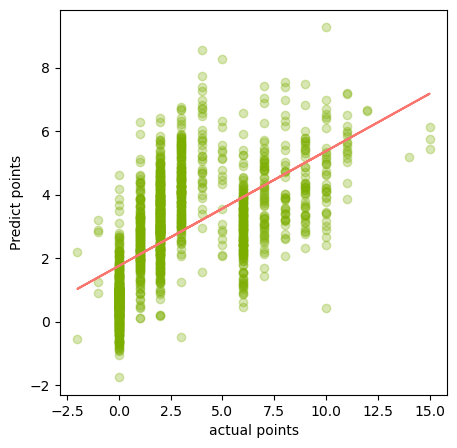

In [865]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5,5))
plt.scatter(x=y_gks, y=y_lr_train_pred_gks, c="#7CAE00" ,alpha=0.3)

z = np.polyfit(y_gks, y_lr_train_pred_gks, 1)
p = np.poly1d(z)

plt.plot(y_gks, p(y_gks), '#F8766D')
plt.ylabel('Predict points')
plt.xlabel('actual points')

In [869]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(x_gks, y_gks)

# Predictions
y_pred_gks = model.predict(x_gks_test)

# Evaluation
mae = mean_absolute_error(y_gks_test, y_pred_gks)
r2 = r2_score(y_gks_test, y_pred_gks)
print(f"MAE: {mae}, R²: {r2}")

MAE: 1.6859059980327122, R²: 0.4086147432675866


In [872]:
y_lr_train_pred_gks=model.predict(x_gks)
lr_train_mse_gks = mean_squared_error(y_gks, y_lr_train_pred_gks)

lr_test_mse_gks = mean_squared_error(y_gks_test, y_pred_gks)

In [874]:
lr_train_mse_gks

3.5051873749527536

In [876]:
lr_test_mse_gks

5.270266386441219

## Fwds

In [532]:
from sklearn.linear_model import LinearRegression

In [534]:
reg_fwds = LinearRegression().fit(x_fwds, y_fwds)

In [536]:
y_lr_train_pred_fwds = reg_fwds.predict(x_fwds)
y_lr_test_pred_fwds = reg_fwds.predict(x_fwds_test)

In [538]:

from sklearn.metrics import mean_squared_error, r2_score

lr_train_mse_fwds = mean_squared_error(y_fwds, y_lr_train_pred_fwds)
lr_train_r2_fwds = r2_score(y_fwds, y_lr_train_pred_fwds)

lr_test_mse_fwds = mean_squared_error(y_fwds_test, y_lr_test_pred_fwds)
lr_test_r2_fwds = r2_score(y_fwds_test, y_lr_test_pred_fwds)

In [540]:

print('LR MSE (Train): ', lr_train_mse_fwds)
print('LR R2 (Train): ', lr_train_r2_fwds)
print('LR MSE (Test): ', lr_test_mse_fwds)
print('LR R2 (Test): ', lr_test_r2_fwds)

LR MSE (Train):  1.2065022689782827
LR R2 (Train):  0.8833821555803865
LR MSE (Test):  1.7465589324112258
LR R2 (Test):  0.8416054467792677


Text(0.5, 0, 'Actual')

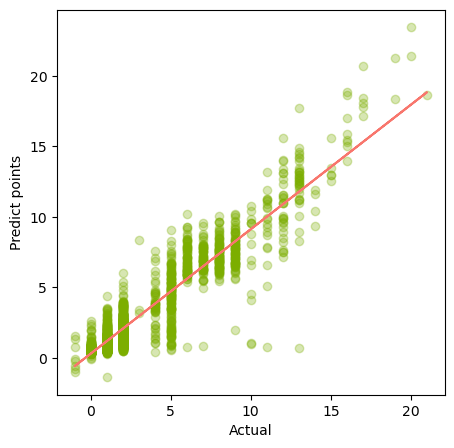

In [542]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5,5))
plt.scatter(x=y_fwds, y=y_lr_train_pred_fwds, c="#7CAE00" ,alpha=0.3)

z = np.polyfit(y_fwds, y_lr_train_pred_fwds, 1)
p = np.poly1d(z)

plt.plot(y_fwds, p(y_fwds), '#F8766D')
plt.ylabel('Predict points')
plt.xlabel('Actual')

In [23]:
from sklearn.linear_model import SGDRegressor

In [29]:
model = SGDRegressor(max_iter=2000, tol=None)

In [31]:
model.partial_fit(X_train_gks, y_train_gks)

SGDRegressor(max_iter=2000, tol=None)

In [33]:
# URL of the CSV file (example)
url = "https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2022-23/gws/merged_gw.csv"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(url)

gks=df.loc[df['position']=="GK"]
defs=df.loc[df['position']=="DEF"]
mids=df.loc[df['position']=="MID"]
fwds=df.loc[df['position']=="FWD"]

y_gks=gks['total_points']
y_defs=defs['total_points']
y_mids=mids['total_points']
y_fwds=fwds['total_points']

x_gks=gks.drop(['total_points', 'name', 'position', 'team', 'starts', 'kickoff_time'], axis =1)
x_defs=defs.drop(['total_points', 'name', 'position', 'team', 'starts', 'kickoff_time'], axis =1)
x_mids=mids.drop(['total_points', 'name', 'position', 'team', 'starts', 'kickoff_time'], axis =1)
x_fwds=fwds.drop(['total_points', 'name', 'position', 'team', 'starts', 'kickoff_time'], axis =1)

X_train_gks, X_test_gks, y_train_gks, y_test_gks = train_test_split(
  x_gks, y_gks, random_state=104,test_size=0.2, shuffle=False)

In [37]:
y_pred = model.predict(X_test_gks)

In [43]:

from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test_gks, y_pred)
r2 = r2_score(y_test_gks, y_pred)



In [45]:
mse

1.7030125561088398e+41

In [47]:
r2

-4.391584760684341e+40